<a href="https://colab.research.google.com/github/anwishn/ESAA_OB_23-1/blob/main/0313_hw_%EB%AA%A8%EB%8D%B8_%ED%9B%88%EB%A0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 머신러닝 텐서플로 4장 모델 훈련 p.157-202

# Chapter 4. 모델 훈련

## 4.1 선형 회귀

**선형 회귀 모델**

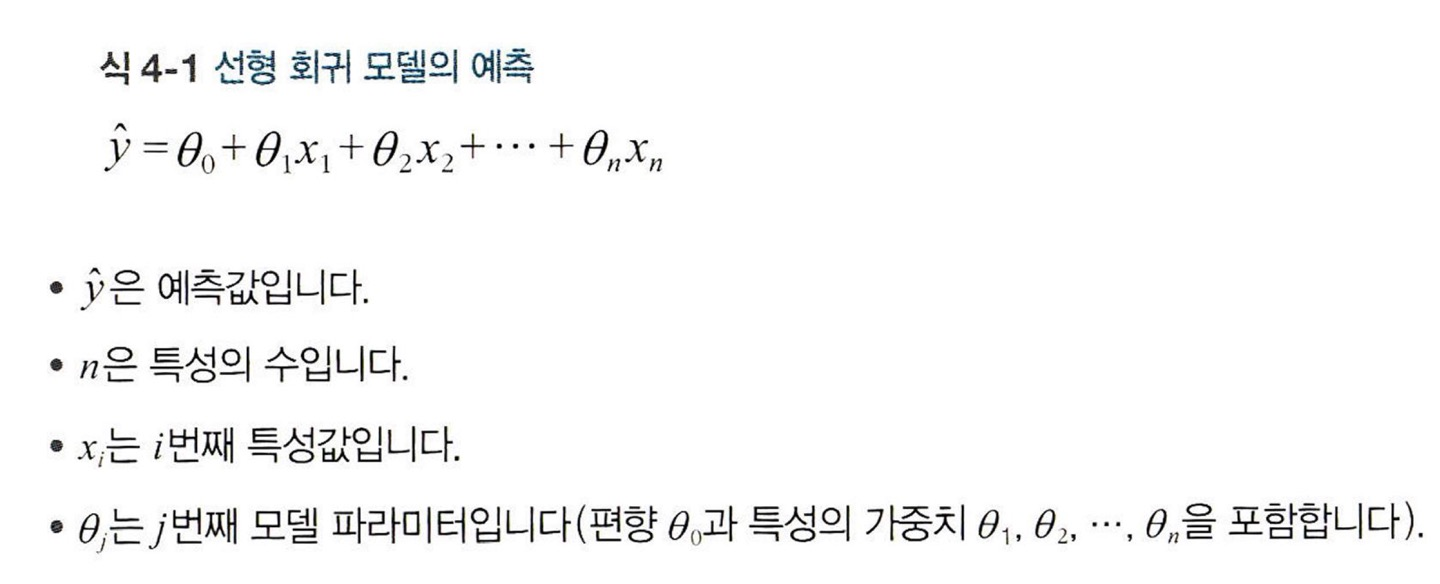

모델 훈련시킨다 = 모델이 훈련 세트에 가장 잘 맞도록 모델 파라미터 설정

-> 모델이 훈련 데이터에 얼마나 잘 들어맞는지 측정

=> 대표적 성능 측정 지표 : 평균 제곱근 오차(RMSE)

=> RMSE 최소화하는 세타 찾기 -> 평균 제곱 오차(MSE) 최소화하는 것이 더 간단

### 4.1.1 정규방정식

**정규방정식** : 비용 함수를 최소화하는 세타 값 찾기 위한 공식

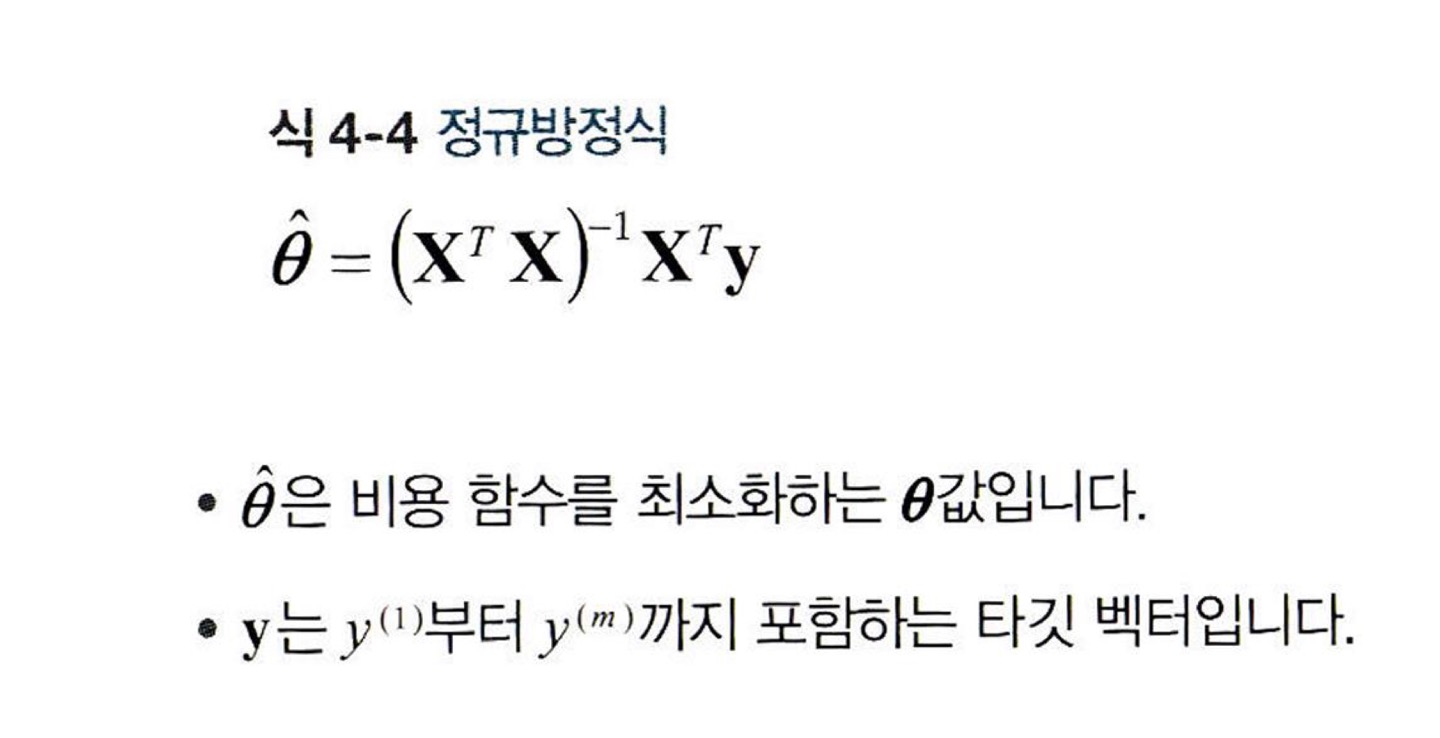

In [37]:
# 선형처럼 보이는 데이터 생성
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

In [38]:
# 정규방정식 사용해 theta hat 계산
X_b = np.c_[np.ones((100,1)), X]  # 모든 샘플에 x0 = 1을 추가합니다.
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [39]:
theta_best

array([[4.12715896],
       [3.03714804]])

In [40]:
# theta hat 사용해 예측
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2,1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.12715896],
       [10.20145504]])

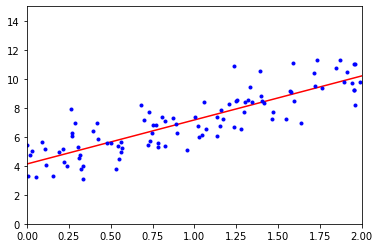

In [41]:
# 모델의 예측을 그래프에 나타내기
import matplotlib.pyplot as plt

plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [42]:
# 사이킷런에서 선형 회귀 수행
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_
lin_reg.predict(X_new)

array([[ 4.12715896],
       [10.20145504]])

LinearRegression 클래스는 **scipy.linalg.lstsq()** 함수 기반으로

In [43]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.12715896],
       [3.03714804]])

> theta hat = (X)+ y

X+ : X의 유사역행렬 

**np.linalg.pinv()** 함수 사용

* 특잇값 분해(SVD)라 부르는 표준 행렬 분해 기법 사용
  + X = U * sigma * V.T 로 분해
  + X+ = V * sigma+ * U.T로 계산
  + 실제로 m<n이거나 어떤 특성이 중복되어 행렬 X.T*X의 역행렬이 없다면 정규 방정식 작동x -> 유사역행렬은 항상 구할 수 있다

In [44]:
np.linalg.pinv(X_b).dot(y)

array([[4.12715896],
       [3.03714804]])

### 4.1.2 계산 복잡도

* 정규방정식은 (n+1) x (n+1) 크기가 되는 X.T*X의 역행렬 계산 -> 일반적으로 O(n^2.4)에서 O(n^3) 사이

* LinearRegression 클래스가 사용하는 SVD 방법은 약 O(n^2)

> * (정규방정식이나 다른 알고리즘으로) 학습된 선형 회귀 모델은 예측이 매우 빨라.
* 예측 계산 복잡도는 샘플 수와 특성 수에 선형적
* 특성이 매우 많고 훈련 샘플이 너무 많아 메모리에 모두 담을 수 없을 때 적합

## 4.2 경사 하강법

**경사 하강법**(GD) : 여러 종류의 문제에서 최적의 해법을 찾을 수 있는 일반적인 최적화 알고리즘

=> 비용 함수를 최소화하기 위해 반복해서 파라미터를 조정해가는 것

theta를 임의의 값으로 시작(무작위 초기화) -> 조금씩 비용 함수가 감소되는 방향으로 진행 -> 알고리즘이 최솟값에 수렴할 때까지 점진적으로 향상

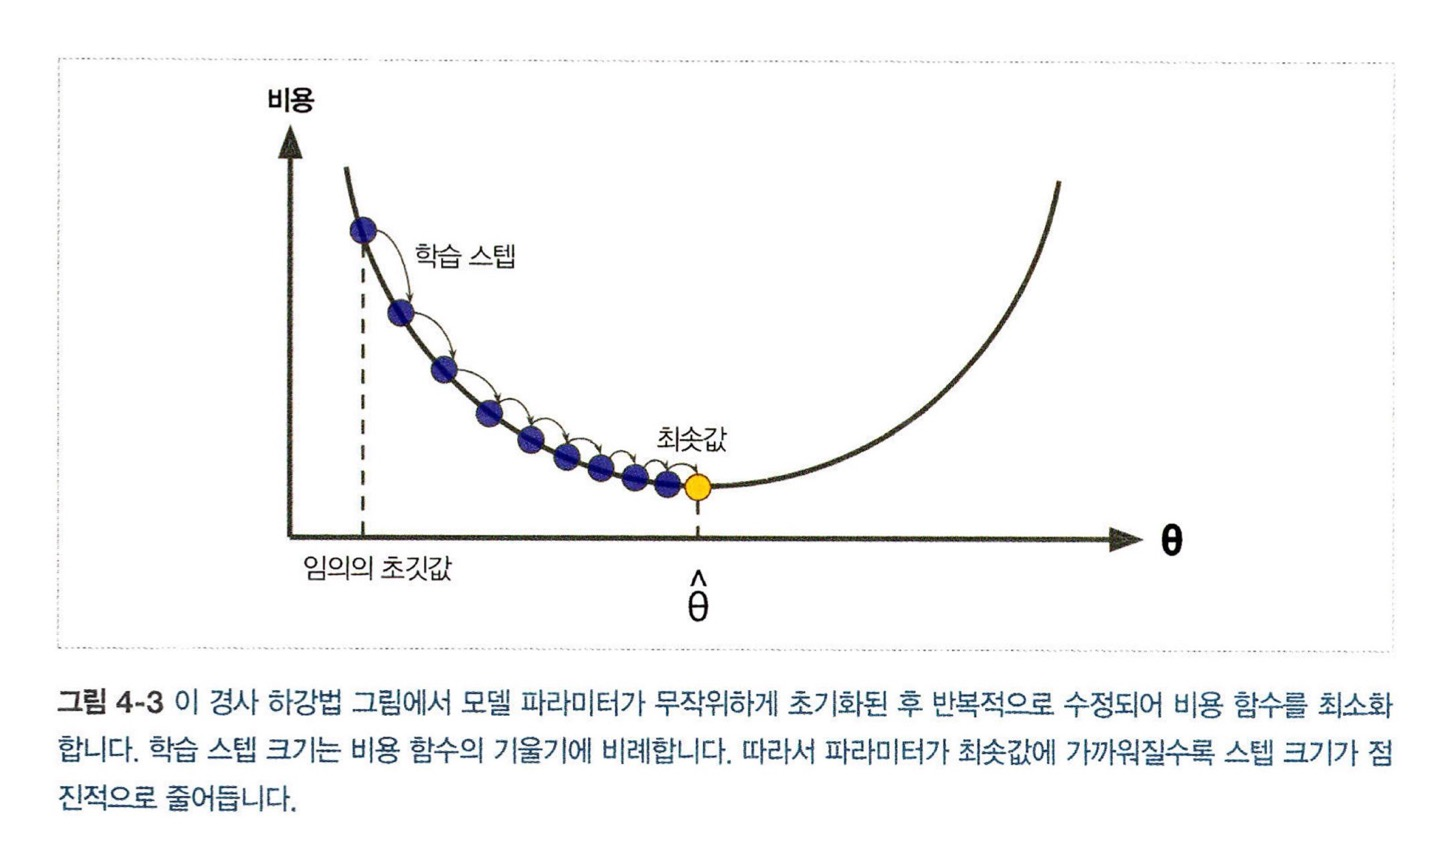

* 중요한 파라미터 = 스텝의 크기 -> 학습률 파라미터로 결정
  + 학습률이 너무 작으면 반복 많이 진행해야해 -> 시간 오래 걸려
  + 학습률이 너무 크면 반대편으로 건너뛰게 되어 -> 알고리즘을 더 큰 값으로 발산하게 만들어

* 경사 하강법의 두 가지 문제점
  + 알고리즘이 왼쪽에서 시작 -> 전역 최솟값보다 덜 좋은 지역 최솟값에 수렴
  + 알고리즘이 오른쪽에서 시작 -> 평탄한 지역 지나기 위해 시간 오래 걸리고 일찍 멈추게 돼 -> 전역 최솟값에 도달x

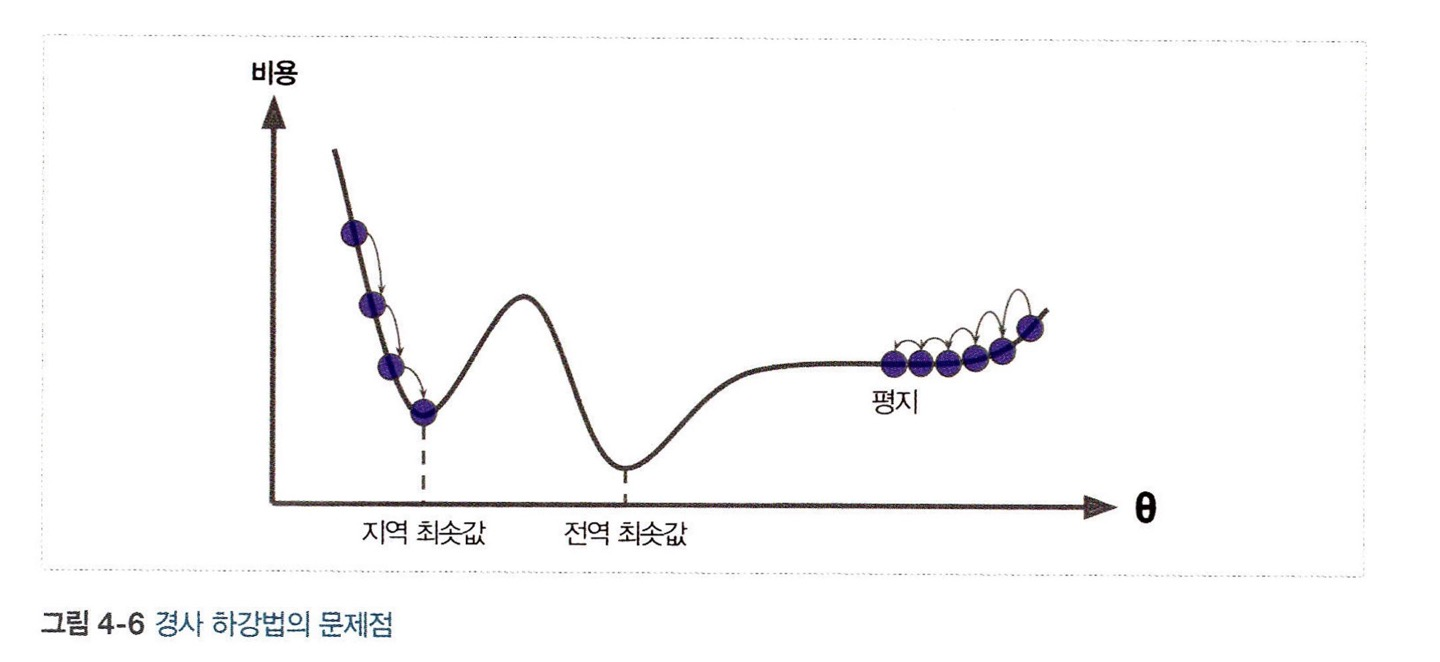

* 선형 회귀를 위한 MSE 비용 함수
  + 볼록 함수 -> 지역 최솟값이 없고 하나의 전역 최솟값만 있다
  + 연속된 함수이고 기울기가 갑자기 변하지x
  + => 경사 하강법이 전역 최솟값에 가깝게 접근할 수 있다는 것 보장

### 4.2.1 배치 경사 하강법

**배치 경사 하강법** : 각 모델 파라미터 theta(j)에 대해 비용 함수의 그레이디언트를 계산해 구현

theta(j)가 조금 변경될 때 비용 함수가 얼마나 바뀌는지 계산 = 편도함수

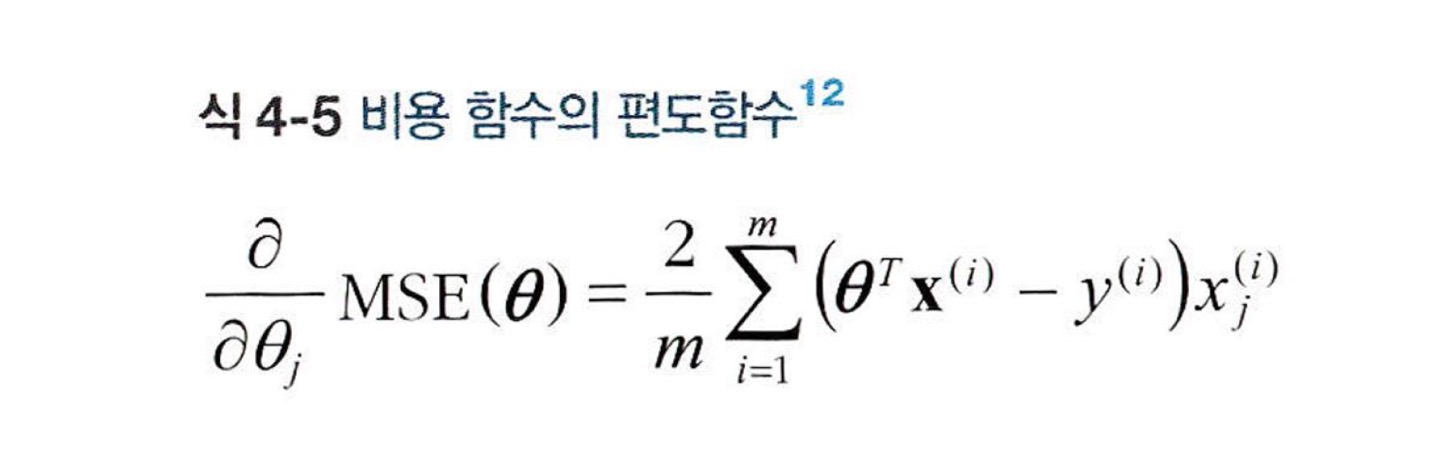

편도함수를 각각 계산하는 대신 한꺼번에 계산

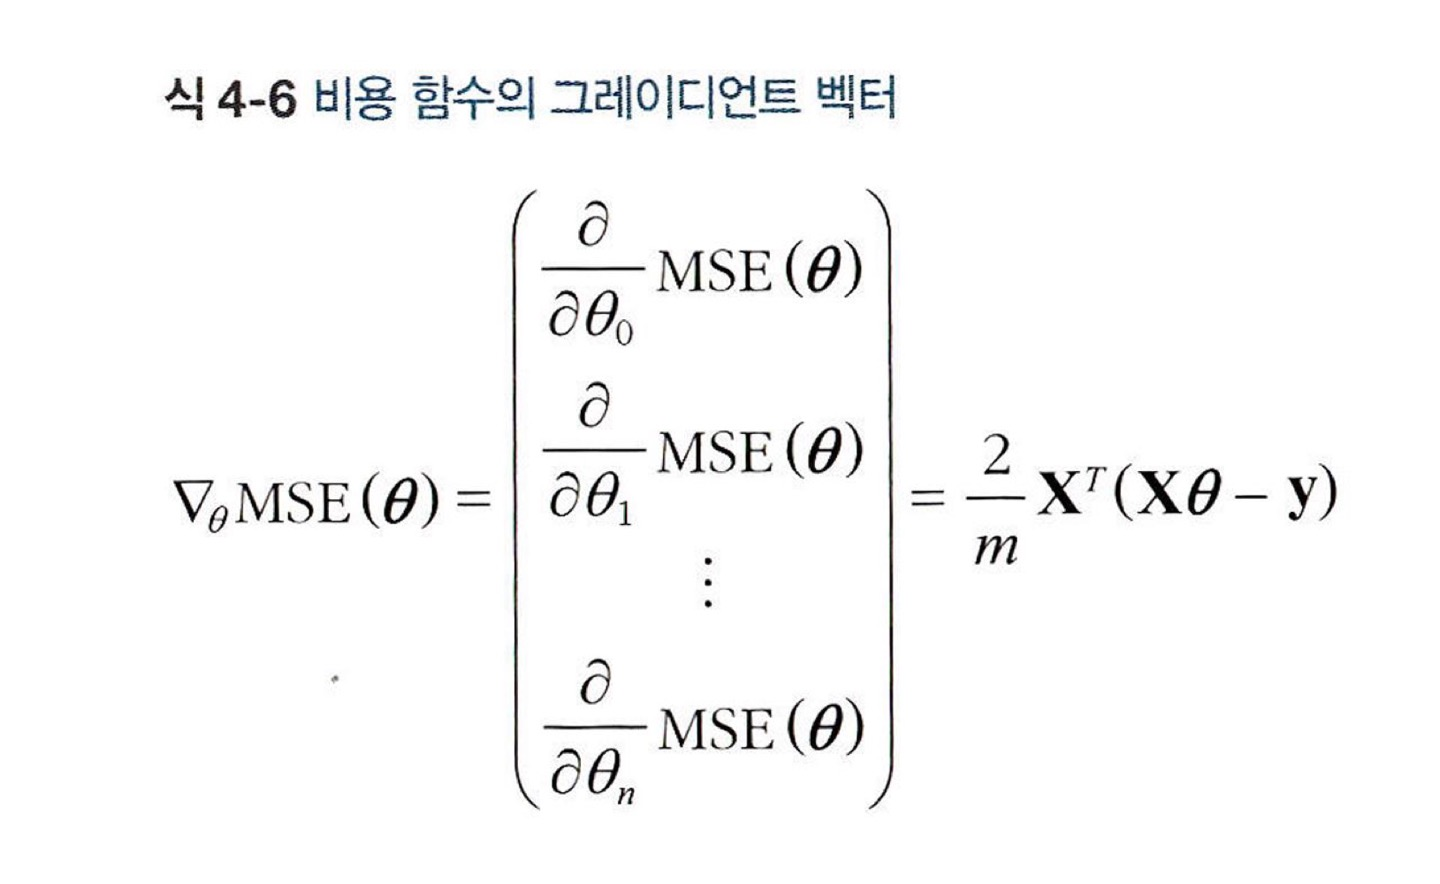

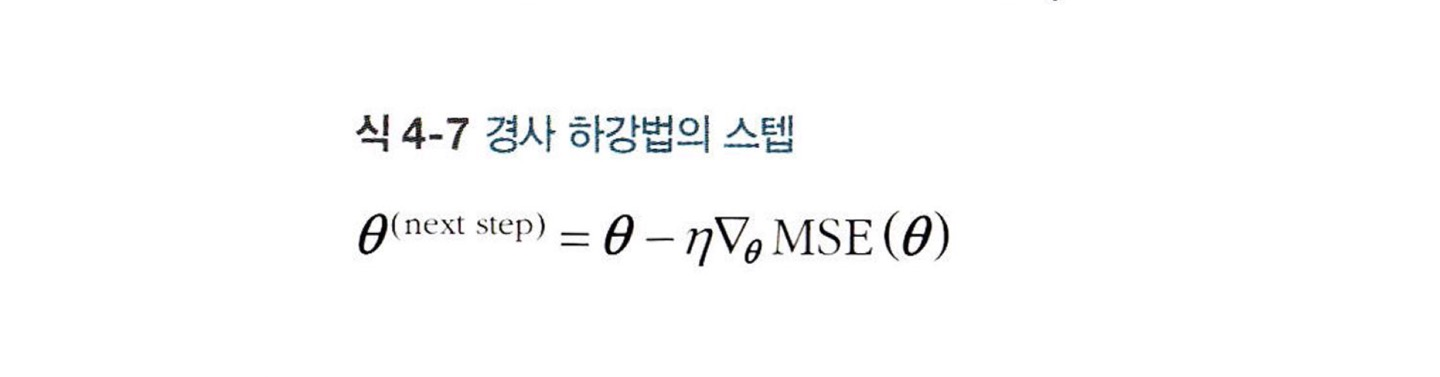

In [45]:
eta = 0.1   # 학습률
n_iterations = 1000
m = 100

theta = np.random.randn(2,1)   # 무작위 초기화

for iteration in range(n_iterations):
  gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
  theta = theta - eta * gradients

In [46]:
theta

array([[4.12715896],
       [3.03714804]])

* 세 가지 다른 학습률 사용하여 진행한 경사 하강법의 스텝 처음 10개

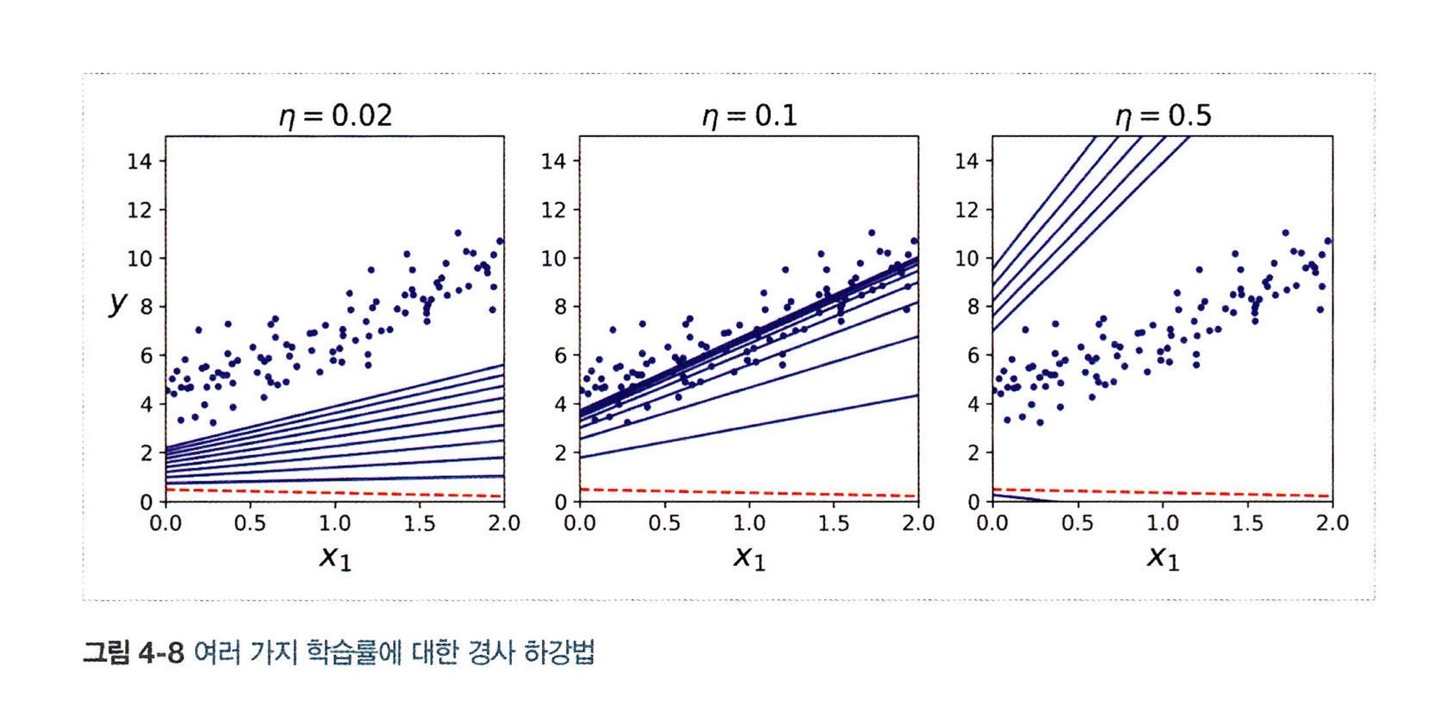

>* 왼쪽은 학습률이 너무 낮아 -> 최적점에 도달하겠지만 시간이 오래 걸려.
* 가운데는 학습률 아주 적당. 반복 몇 번 만에 이미 최적점에 수렴
*오른쪽은 학습률이 너무 높아 -> 스텝마다 최적점에서 점점 더 멀어져 발산

=> 적절한 학습률 찾으려면 그리드 탐색 사용

* 그리드 탐색에서 수렴하는 데 너무 오래 걸리는 모델 막기 위해 반복 횟수 제한 -> 반복 횟수는 어떻게 지정?

반복 횟수를 아주 크게 지정하고 그레이디언트 벡터가 아주 작아지면, 즉 벡터의 노름이 어떤 값(허용오차)보다 작아지면 경사 하강법이 최솟값에 도달한 것. 알고리즘 중지

### 4.2.2 확률적 경사 하강법

배치 경사 하강법 의 가장 큰 문제 = 매 스텝에서 전체 훈련 세트 사용해 그레이디언트 계산. 훈련 세트 커지면 매우 느려져.

<-> 

**확률적 경사 하강법** : 매 스텝에서 한 개의 샘플을 무작위로 선택하고 그 하나의 샘플에 대한 그레이디언트 계산 

>* 알고리즘 확실히 빨라. 매우 큰 훈련 세트도 훈련o.
* 확률적 -> 훨씬 불안정. 시간 지나면 최솟값에 매우 근접하겠지만 요동 지속되면서 최솟값에 안착하지x.확률적 경사 하강법이 배치 경사 하강법보다 전역 최솟값을 찾을 가능성 높아 

무작위성은 지역 최솟값에서 탈출시켜줘 but 알고리즘을 전역 최솟값에 다다르지 못하게 해

-> 딜레마 해결 방법
* 학습률을 점진적으로 감소시킨다
  + 시작할 때 학습률 크게 하고, 점차 작게 줄여서 알고리즘이 전역 최솟값에 도달
  + 매 반복에서 학습률 결정하는 함수 = 학습 스케줄

In [47]:
# 학습 스케줄 사용한 확률적 경사 하강법의 구현
n_epochs = 50   # 각 반복 = 에포크
t0, t1 = 5,50   # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
  return t0 / (t + t1)

theta = np.random.randn(2,1)   # 무작위 초기화

for epoch in range(n_epochs):
  for i in range(m):
    random_index = np.random.randint(m)
    xi = X_b[random_index:random_index+1]
    yi = y[random_index:random_index+1]
    gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(epoch * m + i)
    theta = theta - eta * gradients

In [48]:
theta

array([[4.07215341],
       [3.05144711]])

사이킷런에서 SGD 방식으로 선형 회귀 사용하려면 **SGDRegressor** 클래스 사용

In [49]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)  # max_iter : 최대 에포크 횟수. tol : 손실이 줄어들 때까지 실행되는 기준. eta0 : 학습률. penalty : 규제
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [50]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.13960016]), array([3.06028975]))

### 4.2.3 미니배치 경사 하강법

**미니배치 경사 하강법** : 미니배치라 부르는 임의의 작은 샘플 세트에 대해 그레이디언트 계산

* 행렬 연산에 최적화된 하드웨어, 특히 GPU 사용해서 얻는 성능 향상
* 미니배치 어느 정도 크게 하면 SGD보다 덜 불규칙 but 지역 최솟값에서 빠져나오기는 더 힘들지도

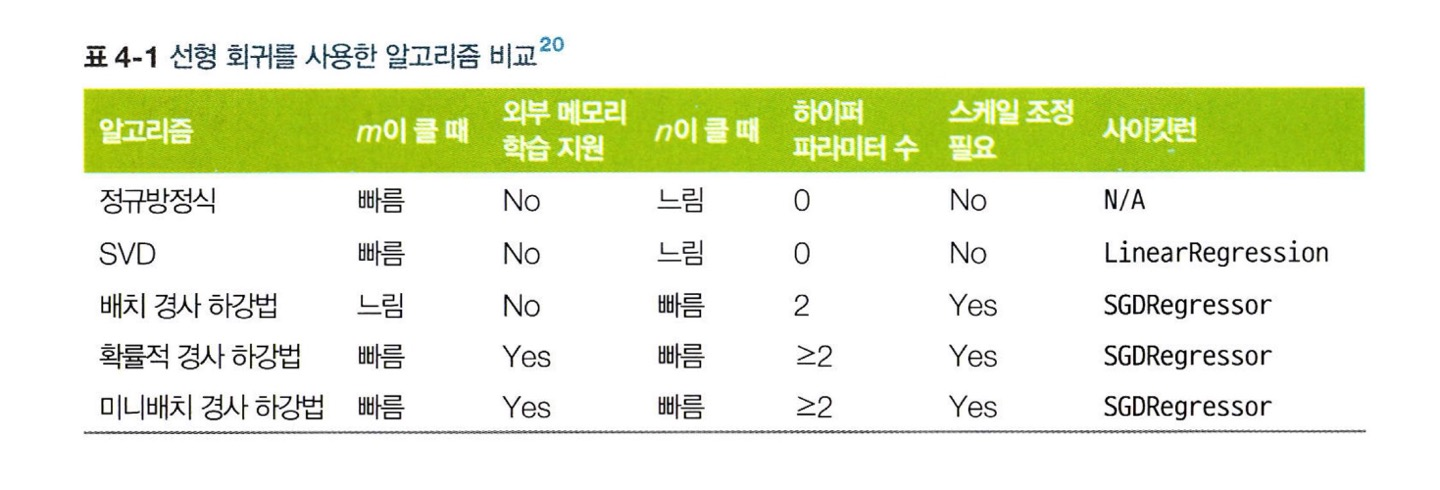

## 4.3 다항 회귀

가지고 있는 데이터가 단순한 직선보다 복잡한 형태라면?

각 특성의 거듭제곱을 새로운 특성으로 추가하고, 이 확장된 특성을 포함한 데이터셋에 선형 모델 훈련시키는 것 = **다항 회귀**

In [51]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

=> 직선은 이 데이터에 잘 맞지 않을 것

* 사이킷런의 **PolynomialFeatures** 사용해 훈련 데이터 변환

In [52]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.59859556])

In [53]:
X_poly[0]

array([-0.59859556,  0.35831664])

In [54]:
# 확장된 훈련 데이터에 LinearRegression 적용
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.17457294]), array([[0.87897597, 0.46064487]]))

* 특성이 여러 개일때 다항 회귀는 이 특성 사이의 관계 찾을 수 있다 (<- 특성 간의 모든 교차항 추가하기 때문)

## 4.4 학습 곡선

고차 다항 회귀를 적용하면 보통의 선형 회귀에서보다 훨씬 더 훈련 데이터에 잘 맞추려 할 것

얼마나 복잡한 모델을 사용할지 어떻게 결정?

* 모델의 일반화 성능 추정 위해 교차 검증 사용
  + 훈련 데이터에서 성능이 좋지만 교차 검증 점수가 나쁘다면 모델이 과대적합된 것 -> 모델이 너무 복잡하다
* 또 다른 방법은 학습 곡선 살펴보기
  + 훈련 세트와 검증 세트의 모델 성능을 훈련 세트 크기의 함수로 나타내
  + 훈련 세트에서 크기가 다른 서브 세트를 만들어 모델을 여러 번 훈련시키면 돼

In [55]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
  plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="훈련 세트")
  plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="검증 세트")

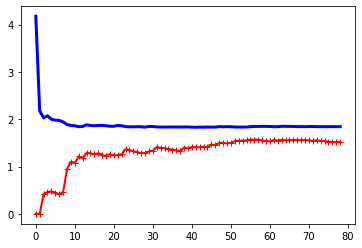

In [56]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

=> **과소적합**된 모델

>* 훈련 데이터 : 샘플이 추가됨에 따라 잡음o. 비선형. 곡선이 어느 정도 평편해질 때까지 오차 계속 상승
* 검증 데이터 : 검증 오차 초기에 매우 커. 샘플 추가됨에 따라 학습되고 검증 오차 천천히 감소. 훈련 세트의 그래프와 가까워져
* 과소적합 모델 = 두 곡선이 수평한 구간을 만들고 꽤 높은 오차에서 매우 가까이 근접해있어

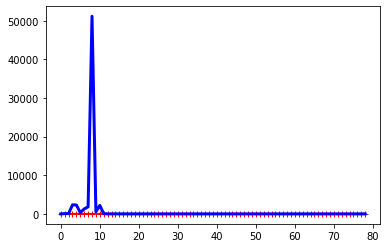

In [57]:
# 10차 다항 회귀 모델의 학습 곡선
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])
plot_learning_curves(polynomial_regression, X, y)

=> 두 그래프의 차이점

>* 훈련 데이터의 오차가 선형 회귀 모델보다 훨씬 낮아
* 두 곡선 사이에 공간 있어 -> 훈련 데이터에서의 모델 선응이 검증 데이터에서보다 훨씬 낫다 = 과대적합 모델의 특징/ 더 큰 훈련 세트 사용하면 두 곡선 점점 가까워져

## 4.5 규제가 있는 선형 모델

과대적합 감소시키는 좋은 방법은 모델 규제하는 것. 선형 회귀 모델에서는 보통 **모델의 가중치 제한**함으로써 규제 가해

-> 각기 다른 방법으로 가중치 제한하는 '릿지'회귀, '라쏘'회귀, 엘라스틱넷

### 4.5.1 릿지 회귀

**릿지 회귀** : 훈련하는 동안에만 비용함수에 규제항 추가

학습 알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력

* 하이퍼파라미터 알파 : 모델을 얼마나 많이 규제할지 조절
  + 알파=0 이면 릿지 회귀 = 선형 회귀
  + 알파가 아주 크면 모든 가중치가 거의 0에 가까워지고 결국 데이터의 평균을 지나는 수평선

* 릿지 회귀는 입력 특성의 스케일에 민감하기 때문에 수행하기 전에 데이터의 스케일을 맞추는 것이 중요

* 릿지 회귀 계산하기 위해 정규방정식 사용할 수도 있고 경사 하강법을 사용할 수도 있다

In [58]:
# 정규방정식을 사용한 릿지 회귀 적용하는 예
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[4.86274542]])

In [59]:
# 확률적 경사 하강법을 사용했을 때
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([4.85303482])

* penalty 매개변수 : 사용할 규제 지정. "l2" = 릿지 회귀

### 4.5.2 라쏘 회귀

**라쏘 회귀** : 릿지 회귀처럼 비용 함수에 규제항을 더하지만 다른 규제 사용.

* 중요한 특징은 덜 중요한 특성의 가중치를 제거하려고 한다는 점. 자동으로 특성 선택을 하고 희소 모델을 만든다.

* 라쏘와 다른 점
  + 파라미터가 전역 최적점에 가까워질수록 그레이디언트 작아진다
  + 알파를 증가시킬수록 최적의 파라미터가 원점에 더 가까워진다

* 라쏘를 사용할 때 경사 하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야한다 

In [60]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.81888406])

=> Lasso 대신 SGDRegressor(penalty="l1") 사용 가능

### 4.5.3 엘라스틱넷

**엘라스틱넷** : 릿지 회귀와 라쏘 회귀를 절충한 모델

* 규제항은 릿지와 라쏘의 규제항을 단순히 더해서 사용. 혼합 정도는 혼합 비율 r 사용해 조절
  + r=0이면 엘라스틱넷 = 릿지 회귀
  + r=1이면 엘라스틱넷 = 라쏘 회귀

* 보통의 선형 회귀(규제가 없는 모델), 릿지, 라쏘, 엘라스틱넷을 언제 사용해야 할까요?
  + 규제가 약간 있는 것이 대부분의 경우에 좋아 일반적으로 평범한 선형 회귀는 피해야
  + 릿지가 기본이 되지만 쓰이는 특성이 몇 개뿐이라고 의심되면 라쏘나 엘라스틱넷
  + 특성 수가 훈련 샘플 수보다 많거나 특성 몇 개가 강하게 연관되어 있을 때는 보통 엘라스틱넷 선호


In [61]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X,y)
elastic_net.predict([[1.5]])

array([4.82181624])

### 4.5.4 조기 종료

**조기 종료** : 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것

에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러 줄어들어. 그러다 다시 상승 -> 모델이 훈련 데이터에 과대적합되기 시작하는 것 의미

In [62]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,      # warm_start = True로 지정하면 fit() 메서드 호출될 때 처음부터 다시 시작하지 않고 이전 모델 파라미터에서 훈련 이어가  # tol 오류나 None으로 수정
                       penalty=None, learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)   # 훈련을 이어서 진행합니다.
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

## 4.6 로지스틱 회귀

**로지스틱 회귀** : 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용

* 이진 분류기
  + 추정 확률이 50% 넘으면 모델은 그 샘플이 해당 클래스에 속한다 예측 = 레이블이 '1'인 양성 클래스
  + 클래스에 속하지 않는다 예측 = 레이블이 '0'인 음성 클래스

### 4.6.1 확률 추정

어떻게 작동? 

* 입력 특성의 가중치 합 계산. 결괏값의 로지스틱을 출력.

* 로지스틱은 0과 1 사이의 값을 출력하는 시그모이드 함수

### 4.6.2 훈련과 비용 함수

어떻게 훈련?

* 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터 세타를 찾는 것

* 음성 샘플의 확률을 0에 가깝게 추정하거나 양성 샘플의 확률을 1에 가깝게 추정하면 비용은 0에 가까워질 것

**로그 손실** : 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 것 

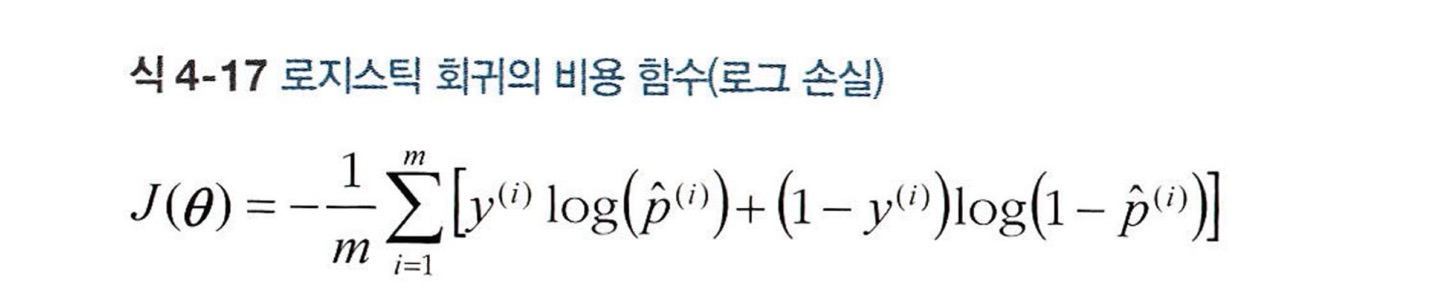

-> 이 비용함수의 최솟값 계산하는 알려진 해는 없지만 볼록 함수이므로 경사 하강법이 전역 최솟값을 찾는 것 보장

### 4.6.3 결정 경계

In [63]:
# 데이터 로드
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
X = iris["data"][:,3:]   # 꽃잎의 너비
y = (iris["target"]==2).astype(np.int)   # 1 Iris-Virginica면 1, 그렇지 않으면 0

<ipython-input-63-3e6c79f84039>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"]==2).astype(np.int)   # 1 Iris-Virginica면 1, 그렇지 않으면 0


In [64]:
# 로지스틱 회귀 모델 훈련
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

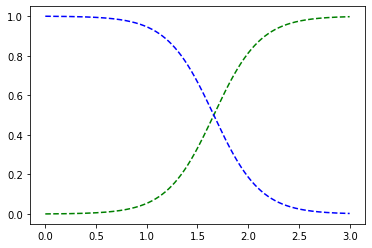

In [65]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률 계산
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], "g--", label="Iris virginica")
plt.plot(X_new, y_proba[:,0], "b--", label="Not virginica")

=> 두 극단 사이에서 분류 확실하지 않지만 가장 가능성 높은 클래스 반환할 것. 1.6cm 근방에서 **결정 경계**

In [66]:
log_reg.predict([[1.7],[1.5]])

array([1, 0])

* 로지스틱 회귀 모델도 l1, l2 페널티 사용하여 규제 가능. 사이킷런 l2 페널티를 기본으로 해
  + 모델 규제 강도 조절하는 하이퍼파라미터는 alpha의 역수인 C. C가 높을수록 모델의 규제 줄어들어

### 4.6.4 소프트맥스 회귀

**소프트맥스 회귀** : 직접 다중 클래스 지원하도록 일반화

소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 계산 -> 소프트맥스 함수 적용 -> 각 클래스의 확률 추정

샘플에 대해 각 클래스의 점수가 계산되면 소프트맥스 함수 통과시켜 클래스 k에 속할 확률 추정. 이 함수는 각 점수에 지수 함수를 적용한 후 정규화 -> 이 점수를 로짓 또는 로그-오즈

* 추정 확률이 가장 높은 클래스 선택

* 한 번에 하나의 클래스만 예측. 종류가 다른 붓꽃 같이 상호 배타적인 클래스에서만 사용해야해. (하나의 사진에서 여러 사람의 얼굴 인식하는데 사용x)

* 훈련 방법
  + 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것이 목표
  + 크로스 엔트로피 비용 함수 최소화하는 것

사이킷런의 LogisticRegression은 클래스가 둘 이상일 때 기본적으로 일대다(OvA) 전략 사용 -> 소프트맥스 회귀 사용하려면?
>* multi_class 매개변수를 "multinomial"로 바꾸면 소프트맥스 회귀 사용 가능
* solver 매개변수에 "lbfgs"와 같이 소프트맥스 회귀 지원하는 알고리즘 지정해야해
* 기본적으로 하이퍼파라미터 C 사용하여 조절할 수 있는 l2 규제 적용

In [67]:
X = iris["data"][:, (2,3)]
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X,y)

LogisticRegression(C=10, multi_class='multinomial')

In [68]:
softmax_reg.predict([[5,2]])

array([2])

In [69]:
softmax_reg.predict_proba([[5,2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])